In [1]:
import torch
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import os
from PIL import Image
import cv2 as cv

from src.factory import get_preprocessing, get_data_loader, get_model
from sklearn.metrics import confusion_matrix

In [80]:
base_path = '../imagewoof2/'
csv_name = 'noisy_imagewoof.csv'

preprocess_conf = {"base_path": base_path, "csv_name": csv_name, "label_name": "noisy_labels_0"}
val_conf = {"data_path": base_path, "batch_size": 32, "num_workers": 4}

preprocess = get_preprocessing(**preprocess_conf)
val_dataloader = get_data_loader(*preprocess.get_valid_data(), **val_conf)

In [78]:
model_conf = {'backbone': 'resnet50', 'checkpoint': './checkpoints/ResNet/resnet50-epoch=19-valid_loss=1.47.ckpt'}
model = get_model(**model_conf)
model.eval()

WoofTrainModule(
  (model): WoofModel(
    (feature_extraction): ResNet(
      (feature_extracor): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

In [4]:
y_pred = []
y_true = []
i = 0
for inp, labels in val_dataloader:
    output = model(inp)
    output = (torch.max(output, 1)[1]).data.cpu().numpy()
    
    y_pred.extend(output)
    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

In [5]:
s = pd.Series(y_true)
s.value_counts()

8    429
7    422
2    418
9    410
0    409
1    408
5    407
4    401
6    401
3    224
dtype: int64

In [6]:
s = pd.Series(y_pred)
s.value_counts()

8    436
7    429
2    423
1    417
4    407
0    404
6    402
9    401
5    398
3    212
dtype: int64

# Plot confusion matrix

<AxesSubplot:>

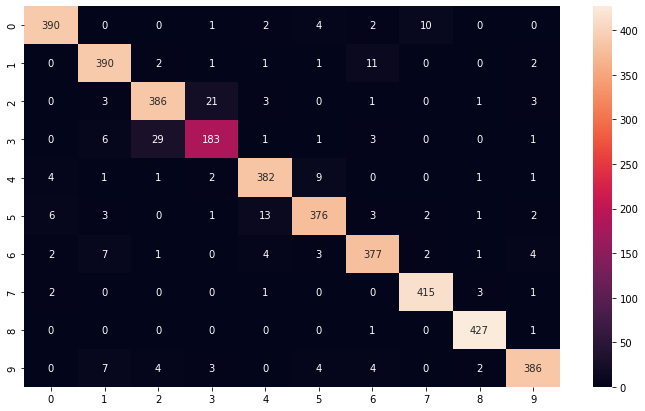

In [7]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix)
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True,  fmt="d")

In [8]:
per_class_recall = cf_matrix.diagonal()/cf_matrix.sum(1)
le = preprocess.le

print("Class         Reacall")
for i, recall in enumerate(per_class_recall):
    print(f'{le.inverse_transform([i])[0]}     {recall}')

Class         Reacall
n02086240     0.9535452322738386
n02087394     0.9558823529411765
n02088364     0.9234449760765551
n02089973     0.8169642857142857
n02093754     0.9526184538653366
n02096294     0.9238329238329238
n02099601     0.940149625935162
n02105641     0.9834123222748815
n02111889     0.9953379953379954
n02115641     0.9414634146341463


In [9]:
per_class_precision = cf_matrix.diagonal()/cf_matrix.sum(0)
print("Class         Precision")
for i, precision in enumerate(per_class_precision):
    print(f'{le.inverse_transform([i])[0]}     {precision}')

Class         Precision
n02086240     0.9653465346534653
n02087394     0.935251798561151
n02088364     0.9125295508274232
n02089973     0.8632075471698113
n02093754     0.9385749385749386
n02096294     0.9447236180904522
n02099601     0.9378109452736318
n02105641     0.9673659673659674
n02111889     0.9793577981651376
n02115641     0.9625935162094763


In [10]:
F1_score = (2 * per_class_recall * per_class_precision) / (per_class_recall + per_class_precision)
print("Class         F1")
for i, f1 in enumerate(F1_score):
    print(f'{le.inverse_transform([i])[0]}     {f1}')

Class         F1
n02086240     0.9594095940959411
n02087394     0.9454545454545454
n02088364     0.9179548156956004
n02089973     0.8394495412844037
n02093754     0.9455445544554455
n02096294     0.9341614906832298
n02099601     0.9389788293897883
n02105641     0.9753231492361928
n02111889     0.9872832369942196
n02115641     0.9519112207151664


We see, that for almost of all classes we have good metrics. But for the class with lowest num of examples (this is n02089973) recall and f1 are lower than for other classes.<br>
We can use weighted cross entropy loss to deal with it. But precision around 0.9 is a quit good, so we can use cross entropy without class weighting.

To deal with noisy labels, we can use label smoothing. But this part of research has been left for the future.

# Sanity check

In [58]:
paths, labels = preprocess.get_train_data()

In [59]:
test_df = pd.DataFrame(zip(paths, labels), columns=['path', 'label'])

In [60]:
test_df

,path,label
0,train/n02115641/n02115641_3995.JPEG,9
1,train/n02115641/n02115641_843.JPEG,9
2,train/n02115641/n02115641_2953.JPEG,9
3,train/n02115641/n02115641_6458.JPEG,9
4,train/n02115641/n02115641_19414.JPEG,9
...,...,...
9020,train/n02089973/n02089973_4754.JPEG,3
9021,train/n02089973/n02089973_1958.JPEG,3
9022,train/n02089973/n02089973_948.JPEG,3
9023,train/n02089973/n02089973_525.JPEG,3


In [61]:
def get_random_imgs(imgs, n, icls):
    return imgs[imgs['label'] == icls].sample(n=n)

In [82]:
def transform_image(image_path):
        img = Image.open(os.path.join(base_path, image_path))
        img = img.convert('RGB')
        
        my_transforms = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.RandomCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.45815152, 0.361242, 0.29348266],
                                    std=[0.2814769, 0.226306, 0.20132513])
        ])

        tensor = my_transforms(img).unsqueeze(0)
        preds = model(tensor)
        preds = torch.max(preds, 1)[1].data.cpu().numpy()

        return preds

In [49]:
def plot_imgs(imgs, icls):
    fig, ax = plt.subplots()
    fig.set_size_inches((12,4))
    ax.set_axis_off()
    fig.suptitle(f"Class {le.inverse_transform([icls])[0]}")

    for i, img_f in enumerate(imgs.iterrows()):
        a = fig.add_subplot(1, 3, i + 1)
        img = cv.cvtColor(cv.imread(os.path.join(base_path, img_f[1][0])), cv.COLOR_BGR2RGB)
        pred = transform_image(img_f[1][0])

        h0, w0 = img.shape[:2]
        scale_w, scale_h = 500/w0, 375/h0
        h, w = int(round(h0 * scale_h)), int(round(w0 * scale_w))

        img = cv.resize(img, (h, w), interpolation=cv.INTER_AREA)

        plt.title(f"Pred class {le.inverse_transform([pred])[0]}")
        plt.axis('off')
        plt.imshow(img)

d:\Projects\ImageWoofCls\venv\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


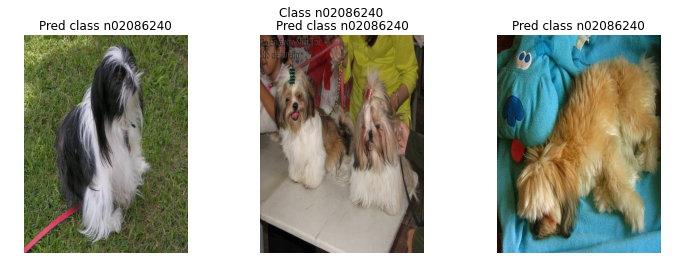

In [83]:
imgs = get_random_imgs(test_df, 3, 0)
plot_imgs(imgs, 0)

d:\Projects\ImageWoofCls\venv\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


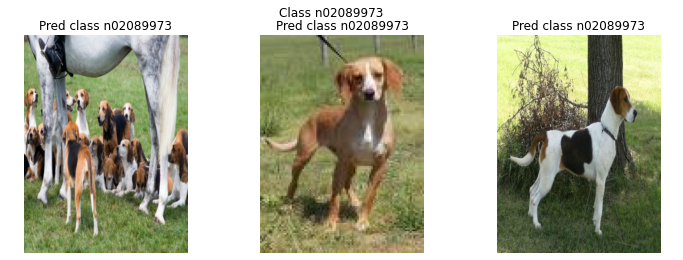

In [84]:
imgs = get_random_imgs(test_df, 3, 3)
plot_imgs(imgs, 3)

d:\Projects\ImageWoofCls\venv\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


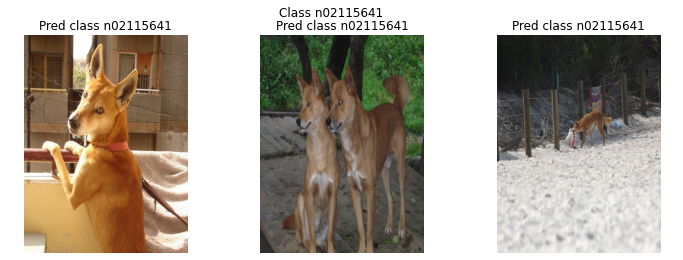

In [85]:
imgs = get_random_imgs(test_df, 3, 9)
plot_imgs(imgs, 9)

## Training process
All training metrics were logged, using tensorboard.

<img src="./imgs/TrainImg1.png" width=600 height=800/>
<img src="./imgs/TrainImg2.png" width=600 height=800/>
<img src="./imgs/TrainImg3.png" width=600 height=800/>